# How to Aggregate Textual Responses via Crowdsourcing

Welcome to this tutorial! We will look at how to apply aggregation methods to a text response and learn from noisy texts in the crowdsourcing setting.

We are going to use some machine learning models and for faster calculating it's better to use GPU. First of all, let's install all the necessary libraries:

In [4]:
%%capture
%pip install pandas
%pip install crowd-kit
%pip install sentence_transformers
%pip install jiwer

So, we want somehow to get one correct answer from the several textual responses. Let's deal with that problem with crowd-kit library and see what we can do with it

In [5]:
from crowdkit.datasets import get_datasets_list, load_dataset
import pandas as pd
import numpy as np

The load_dataset function returns a pair of elements. The first element is the pandas data frame with the crowdsourced data. The second element is the ground truth dataset, whenever possible. The data frame, or df, has three columns: worker, task, and label. The label is set to 0 if the document is rated as non-relevant by the given annotator in the given task, otherwise, the label will be 1. The ground truth dataset df_gt is a pandas series that contains the correct responses to the tasks put to the index of this series.

In [6]:
df, gt = load_dataset('crowdspeech-test-clean')

df['text'] = df['text'].str.lower()

Unpacking crowdspeech-test-clean.zip


Let's see the structure of our dataset

In [7]:
df.columns

Index(['task', 'worker', 'text'], dtype='object')

Checking our dataset

In [8]:
df.columns

Index(['task', 'worker', 'text'], dtype='object')

In [9]:
gt

task
https://tlk.s3.yandex.net/annotation_tasks/librispeech/test-clean/0.mp3       young fitzooth had been commanded to his mothe...
https://tlk.s3.yandex.net/annotation_tasks/librispeech/test-clean/1.mp3       there befell an anxious interview mistress fit...
https://tlk.s3.yandex.net/annotation_tasks/librispeech/test-clean/2.mp3       most of all robin thought of his father what w...
https://tlk.s3.yandex.net/annotation_tasks/librispeech/test-clean/3.mp3       if for a whim you beggar yourself i cannot sta...
https://tlk.s3.yandex.net/annotation_tasks/librispeech/test-clean/4.mp3       but take it whilst i live and wear montfichet'...
                                                                                                    ...                        
https://tlk.s3.yandex.net/annotation_tasks/librispeech/test-clean/2615.mp3    it is evident therefore that the present trend...
https://tlk.s3.yandex.net/annotation_tasks/librispeech/test-clean/2616.mp3    it is also noticeable

Now let's see how we can solve the aggregation problem with text responses. We will use three methods - ROVER, TextRASA, and TextHRRASA. All these methods solve the same problem - text aggregation - but in different ways. 
Let's import them

In [10]:
from crowdkit.aggregation import ROVER
from crowdkit.aggregation import TextHRRASA
from crowdkit.aggregation import TextRASA

At first, we will use Recognizer Output Voting Error Reduction - ROVER. It's a dynamic programming method to align sequences. Next, aligned sequences are used to construct the Word Transition Network (WTN): 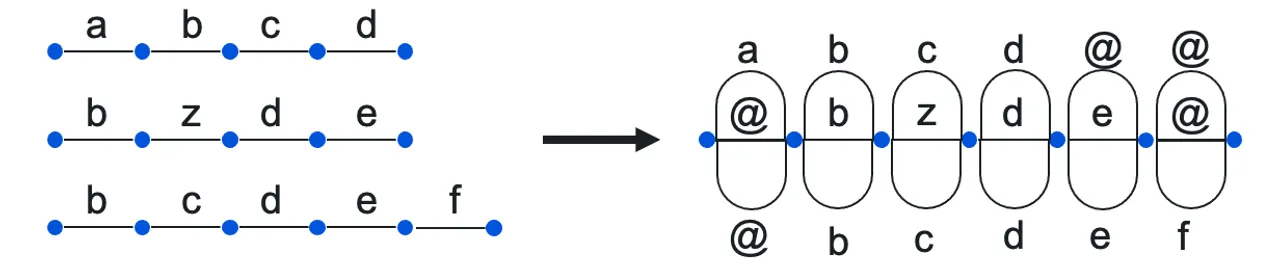
Finally, the aggregated sequence is the result of majority voting on each edge of the WTN.

We need to determine the tokenizer and detokenizer functions. For the tokenizer, we will split a sentence by spaces and for the detokenizer we will glue the words into a string

In [11]:
tokenizer = lambda s: s.split(' ')
detokenizer = lambda tokens: ' '.join(tokens)

result_ROVER = ROVER(tokenizer, detokenizer).fit_predict(df)

The next method is TextRASA. The Reliability Aware Sequence Aggregation (RASA) algorithm consists of three steps:

Step 1. Encode the worker answers into embeddings.

Step 2. Estimate the global workers' reliabilities β by iteratively performing two steps:

For each task, estimate the aggregated embedding:

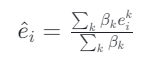
​

 For each worker, estimate the global reliability:

 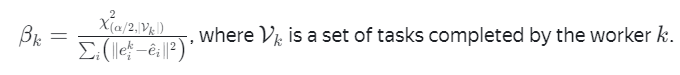
​

​Step 3. Estimate the aggregated result. It is the output which embedding is the closest one to image.png

In [ ]:
from crowdkit.aggregation import TextRASA

result_TextRASA = TextRASA(encoder=model.encode).fit_predict(df)

In [ ]:
result_TextRASA

And the last one is TextHRRASA. 

The Hybrid Reliability and Representation Aware Sequence Aggregation (HRRASA) algorithm consists of four steps:

Step 1. Encode the worker answers into embeddings.

Step 2. Estimate the local workers' reliabilities that represent how well a worker responds to one particular task. The local reliability of the worker 
$k$ on the task $i$ is denoted by $γ_i^k$ and is calculated by incorporating both types of representations:
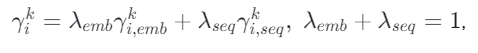

where the $γ^k_{i,emb}$ value is a reliability calculated on embedding, and the $γ^k_{i,seq}$ value is a reliability calculated on output.
The $γ^k_{i,emb}$ value is calculated by the following equation:

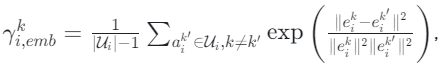

where $U_i$ is a set of workers' responses on task $i$.

The $γ^k_{i,seq}$ value uses some similarity measure $sim$ on the output data, e.g. GLEU similarity on texts:

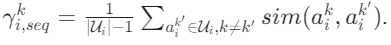

Step 3. Estimate the global workers' reliabilities $β$ by iteratively performing two steps:

For each task, estimate the aggregated embedding:

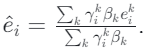

For each worker, estimate the global reliability:

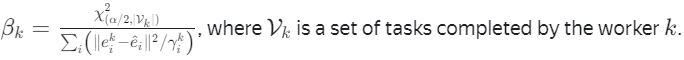

Step 4. Estimate the aggregated result. It is the output which embedding is the closest one to image.png. If calculate_ranks is true, the method also calculates ranks for each worker response as


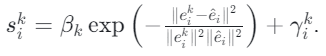

We need to determine the encoder - a callable that takes a text and returns a NumPy array containing the corresponding embedding. For that, we will use the model from sentence_transformers. The model.encode returns the embedding.

In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-mpnet-base-v2')

result_TextHRRASA = TextHRRASA(encoder = model.encode).fit_predict(df)

 Let's compare the results of these methods - we will use word error rate (WER) from jiwer. It is a common metric of the performance of an automatic speech recognition system. This value indicates the percentage of words that were incorrectly predicted. The lower the value, the better the performance of the ASR system with a WER of 0 being a perfect score. Word error rate can then be computed as:
\begin{align}
WER = \frac{S+D+I}{S+D+C},
\end{align}
Where: 
- S is the number of substitutions, is the number of deletions, 
- D is the number of deletions,
- I is the number of insertions, 
- C is the number of correct words.


Let's see the difference!

In [14]:
from jiwer import wer

input_TextRASA = list()
target_TextRASA = list()

# Making target and input lists from TextRASA method and golden set
for i in gt.index:
  input_TextRASA.append(gt.loc[i])
  target_TextRASA.append(result_TextRASA['text'].loc[i])

print('The WER of TextRASA -', wer(target_TextRASA, input_TextRASA))

input_TextHRRASA = list()
target_TextHRRASA = list()

# Making target and input lists from TextHRRASA method and golden set
for i in gt.index:
  input_TextHRRASA.append(gt.loc[i])
  target_TextHRRASA.append(result_TextHRRASA['text'].loc[i])

print('The WER of TextHRRASA -', wer(target_TextHRRASA, input_TextHRRASA))

input_ROVER = list()
target_ROVER = list()

# Making target and input lists from ClosestToAverage method and golden set
for i in gt.index:
  input_ROVER.append(gt.loc[i])
  target_ROVER.append(result_ROVER.loc[i])
print('The WER of ROVER -', wer(target_ROVER, input_ROVER))

The WER of TextRASA - 0.0907894234804838
The WER of TextHRRASA - 0.09415696009165553
The WER of ROVER - 0.07017374889239897


See? We got extremely excellent results by all methods, as expected, the Rover method gave a slightly better result. By the way ROVER can even construct new transcriptions but RASA/HRRASA can only extract one from provided.


Thus, you have solved the problem posed - text aggregation - with the help of the crowd-kit library!